<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90%E6%87%89%E7%94%A8PCA%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90%E6%8F%90%E5%8D%87%E9%A0%90%E6%B8%AC%E7%B5%90%E6%9E%9C_2%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [23]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = data.index % 5
train = data.loc[ mod != 0 ,:]
test = data.loc[ mod == 0 ,:]
print(train.shape)
print(test.shape)

(200, 27)
(50, 27)


In [24]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
1,74.9,105.9,138.6,39.082932,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701
2,60.4,97.9,144.4,40.934064,12.061397,8.788561,1.018949,6.671666,8.024599,10.116494,3.755812,4.855465,4.197693,12.283775,4.139793,3.781476,4.404284,3.863638,3.345833,2.205359,2.984103,1.368210,0.800960,0.414533,0.676800,0.070908,0.169692
3,100.4,114.0,137.0,53.849498,0.152985,0.054995,0.125987,2.097767,1.214444,7.428715,2.663734,6.475165,5.259181,15.397940,6.812319,7.602400,9.434827,8.037266,7.481252,3.877234,8.225184,3.917980,1.569843,0.421814,1.334506,0.127167,0.287296
4,105.7,127.5,154.6,44.225827,0.334270,0.215481,0.153186,2.306365,2.733433,3.013477,0.453959,4.235994,4.640280,8.692144,3.097721,6.825638,9.400184,8.999908,6.979372,5.567792,11.825300,7.673652,3.166715,1.524705,6.164731,0.415157,1.580535
6,106.0,125.4,159.8,54.454027,0.350789,0.220336,0.130728,1.183945,1.376936,3.548836,0.417912,3.073976,5.860175,12.842276,3.848192,4.339943,8.836537,10.087635,6.383659,3.155302,9.465907,7.226622,5.172914,1.604274,6.077852,0.922120,3.873133


In [0]:
y_name = 'C6NP'

In [26]:
corr_res = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False)
corr_res.head(5)

,C6NP
C6NP,1.000000
C6IP,0.945547
C5N,0.865503
C5NP,0.827811
C5IP,0.754047


# def features & y_columns

In [27]:
features = ['T10','T50','T90','N+A']
y_columns = list(corr_res[corr_res[y_name]>0.8].index)
y_columns

['C6NP', 'C6IP', 'C5N', 'C5NP']

# PCA y_columns

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
pca = PCA(n_components=1)

train['pca_1'] = pca.fit_transform(scaler_y.fit_transform(train[y_columns]))
test['pca_1'] = pca.transform(scaler_y.transform(test[y_columns]))

# scaler features

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()

train[features] = scaler_x.fit_transform(train[features])
test[features] = scaler_x.transform(test[features])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [35]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
import warnings 
warnings.simplefilter('ignore')

#算法選擇
model = SVR(C=1)

#交叉驗證表現
val_scores = cross_validate(model,train[features],train['pca_1'],cv=5)
print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

#測試集表現
print('test_scores:')
model.fit(train[features],train['pca_1'])
test['y_pred'] = model.predict(test[features])
metric(test['pca_1'],test['y_pred'])

val_scores: [0.91587125 0.90583621 0.94042588 0.89592268 0.89154105]
val_scores.mean: 0.9099194165845695
test_scores:


,R2,RMSE,mean_absolute_error
pca_1,0.904989,0.580948,0.28019


# line plot

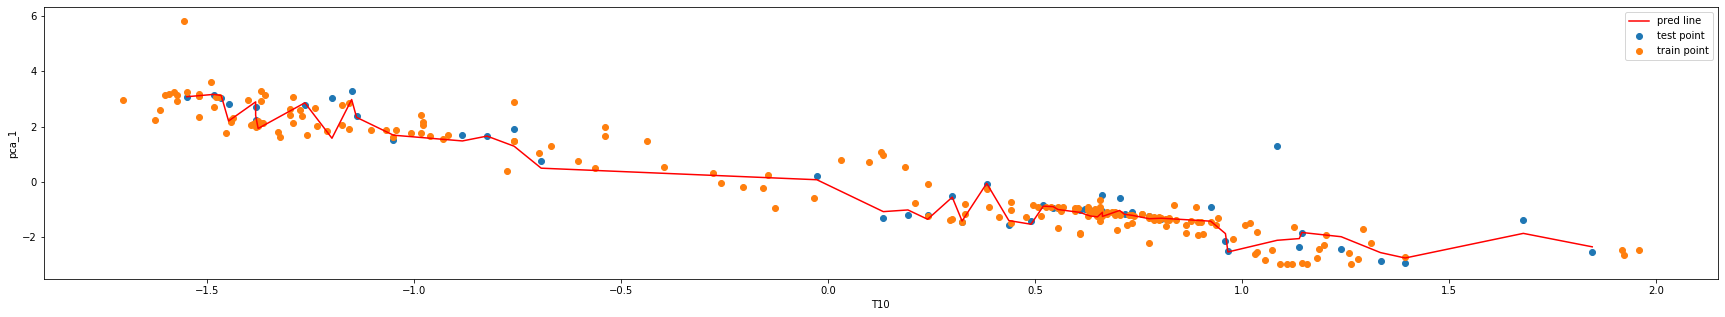

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))

# sorted point
test_point = test.sort_values(by='T10')
train_point = train.sort_values(by='T10')

# y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

# test point
plt.scatter(test_point['T10'],test_point['pca_1'],label='test point')

# train point
plt.scatter(train_point['T10'],train_point['pca_1'],label='train point')

plt.legend()
plt.xlabel('T10')
plt.ylabel('pca_1')
plt.show()

# check out

In [38]:
loss = (test_point['pca_1'] - test_point['y_pred'])**2 # 平方誤差
loss.sort_values(ascending=False).head(5)

95     11.671600
100     2.110993
150     0.401591
60      0.397032
90      0.362529
dtype: float64

In [39]:
ub = loss.mean() + 3 * loss.std()
ub

5.329849547569949

In [40]:
out_index = list(loss[loss>ub].index)
out_index

[95]

# del out

In [0]:
#add out columns
test_point['out'] = False
test_point.loc[out_index ,'out'] = True

#def out_point
out_point = test_point[test_point['out'] == True]

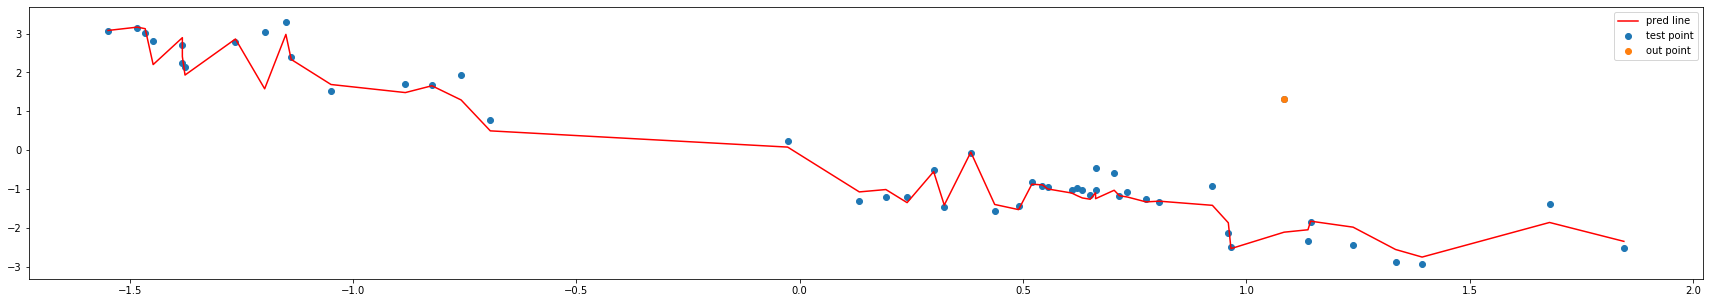

In [42]:
#fig
fig = plt.figure(figsize=(30,5))

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point['pca_1'],label='test point')

#out point
plt.scatter(out_point['T10'],out_point['pca_1'],label='out point')

plt.legend()
plt.show()

# del_out_point_scores:

In [43]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,'pca_1'],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
pca_1,0.97037,0.325872,0.216186


# all scores

In [0]:
y_pred_all = pd.DataFrame(scaler_y.inverse_transform(pca.inverse_transform(test[['pca_1']])),index=test.index,columns=y_columns)
y_test_all = test[y_columns]

In [45]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C6NP,0.924046,0.634335,0.492838
C6IP,0.978591,0.390531,0.311802
C5N,0.947936,0.069953,0.047065
C5NP,0.922874,1.083387,0.918351
AVG,0.943362,0.544552,0.442514


# del out all scores

In [46]:
print(out_index)
y_pred_all = y_pred_all.drop(out_index,axis=0)
y_test_all = y_test_all.drop(out_index,axis=0)

[95]


In [47]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C6NP,0.923577,0.640551,0.500473
C6IP,0.979813,0.382108,0.304153
C5N,0.948650,0.069323,0.046069
C5NP,0.921957,1.094321,0.935389
AVG,0.943499,0.546576,0.446521
